Jon Nordby <jonnord@nmbu.no>


## Theory


### Insertion sort
### Merge sort
 
### Quicksort
### Heapsort
    

### Summary of expected execution times

Best, Average, Worst

Quicksort |	$n\log n$ | $n\log n$ |	$n^{2}$

Merge sort | $n\log ⁡n$ | $n\log ⁡n$ | $n\log ⁡n$

Heapsort | $n \log ⁡n$ | $n\log n$ | $n\log n$

Insertion sort 	$n$ | $n^{2}$ | $n^{2}$
    

https://en.wikipedia.org/wiki/Sorting_algorithm


## Methods


The methods section should include

    your algorithm implementations 
    test for correctness
    functions for generating test data
    functions to collect benchmark data

In addition to the actual code, the section should contain brief descriptions of the code. Provide docstrings, but avoid inline comments in Python code.

Also describe you strategy for collecting benchmark data.




### Test data generation

Test data should be automatically generated. As default items to be sorted, use NumPy arrays filled with integers, but also use strings. Test at least with the following types of data

    sorted in ascending order
    sorted in descending order
    identical values
    randomly shuffled data
    real-life data




In [1]:
%load_ext line_profiler

%matplotlib inline
import matplotlib

import math
import random
import time
import timeit
import statistics

import numpy
import pandas
import string
import hypothesis.strategies

### Correctness

Correctness is checked against Python as oracle


In [51]:
def random_integers(length, number_range=30000000):
    r = number_range
    return [random.randint(-r, r) for _ in range(length)]

def random_floats(length, number_range=30000000):
    r = number_range
    return [random.uniform(-r, r) for _ in range(length)]
    
def random_numpy(length):
    return numpy.random.random(length)

def random_strings(length, stringlength=20):
    t = hypothesis.strategies.text(alphabet=string.printable, average_size=stringlength)
    return [ t.example() for _ in range(length) ]

def identical_strings(length, val=None):
    if val is None:
        val = random_strings(1)[0]
    return [ val for _ in range(length) ]

def identical_integers(length, val=None):
    if val is None:
        val = random.randint(0, 100000)
    return [ val for _ in range(length) ]

def ascending_integers(length, start=0):
    return [ start + i for i in range(length) ]

def descending_integers(length):
    return reversed(ascending_integers(length))

input_data_types = {
    ascending_integers,
    descending_integers,
    identical_integers,
    random_integers,
    random_strings,
}
# FIXME: add real-life data,
# string filenames from disk
# numbers from some spreadsheet

def test_sort_with_data(sort, data_generator, examples=50, **kwargs):
    for t in range(examples): 
        data = data_generator(**kwargs)
        expected = sorted(data)
        out = data # in-place sorting
        sort(out)
        assert list(out) == expected, "{} != {}".format(out, expected)
    
def test_sort(sort, N=10):
    test_sort_with_data(sort, random_strings, length=N)
    test_sort_with_data(sort, random_integers, length=N)
    test_sort_with_data(sort, random_numpy, length=N)
    return 'tests passed'

def python_sort(data):
    data.sort()
    return None
        
test_sort(python_sort)

'tests passed'

### Insertion sort


In [11]:
def insertion_sort(s):
    for i in range(1, len(s)):
        val = s[i]
        j = i - 1
        while j >= 0 and s[j] > val:
            s[j+1] = s[j]
            j = j - 1
        s[j+1] = val
    return s

test_sort(insertion_sort)

'tests passed'

### Merge sort


In [28]:
# Checking for empty instead of using Inf as sentinel value
def merge_check_empty(arr, start, mid, end):
    left = arr[start:mid+1]
    right = arr[mid+1:end+1]
    l = 0
    r = 0
    left_length = len(left)
    right_length = len(right)
    for a in range(start, end+1):
        if not l < left_length:
            # left has been exhausted, fill remaining right
            arr[a] = right[r]
            r += 1
        elif not r < right_length:
            # right has been exhausted, fill remaining left
            arr[a] = left[l]
            l += 1
        elif left[l] <= right[r]:
            arr[a] = left[l]
            l += 1
        else:
            arr[a] = right[r]
            r += 1

def _merge_sort_check(arr, start, end):
    if start < end:
        mid = int((start + end) / 2)
        _merge_sort_check(arr, start, mid)
        _merge_sort_check(arr, mid+1, end)
        merge_check_empty(arr, start, mid, end)
    return arr

def mergesort(arr):
    return _merge_sort_check(arr, 0, len(arr)-1)

test_sort(mergesort)

AssertionError: [ 0.05681062  0.05681062  0.05681062  0.05681062  0.05681062  0.35431885
  0.35431885  0.52825609  0.52825609  0.70335076] != [0.056810622664781762, 0.07020067686729925, 0.19873870889485779, 0.35431885237542604, 0.52825608665728829, 0.63970376214369484, 0.70335075714351913, 0.74465565487769714, 0.77030695354236023, 0.94683015658211533]

### Heapsort


In [13]:
def max_heapify_iterative(H, length, top):
    p = top
    while True:
        l = 2*p + 1
        r = 2*p + 2
        largest = p
        if l < length and H[l] > H[largest]:
            largest = l
        if r < length and H[r] > H[largest]:
            largest = r
        if largest != p:
            H[largest], H[p] = H[p], H[largest]
            p = largest
        else:
            break

def build_max_heap_iterative(A, length):
    H = A
    for i in range(length//2, -1, -1):
        max_heapify_iterative(H, length, i)
    return H

def heapsort(A):
    length = len(A)
    build_max_heap_iterative(A, length)
    for i in range(length-1, 0, -1):
        A[0], A[i] = A[i], A[0]
        length -= 1
        max_heapify_iterative(A, length, 0)

test_sort(heapsort)

'tests passed'

In [ ]:
%timeit test_sort(heapsort, N=10000)

### Quicksort



In [14]:
def partition(A, low, high):
    pivot = A[high]
    i = low-1
    for j in range(low, high):
        if A[j] <= pivot:
            i += 1
            A[i], A[j] = A[j], A[i]

    #print('pivot', i+1, p-1)
    if A[high] < A[i+1]:
        A[i+1], A[high] = A[high], A[i+1]
    return i+1

def _quicksort(A, low, high):
    if low < high:
        pivot = partition(A, low, high)
        #print('{} {}'.format(q-1 - p, r - q+1))
        _quicksort(A, low, pivot-1)
        _quicksort(A, pivot+1, high)
    
def quicksort(A):
    return _quicksort(A, 0, len(A)-1)

test_sort(quicksort, N=50)

'tests passed'

In [40]:
import numba
@numba.jit()
def partition_numba(A, low, high):
    pivot = A[high]
    i = low-1
    for j in range(low, high):
        if A[j] <= pivot:
            i += 1
            A[i], A[j] = A[j], A[i]

    if A[high] < A[i+1]:
        A[i+1], A[high] = A[high], A[i+1]
    return i+1

@numba.jit()
def _quicksort_numba(A, low, high):
    if low < high:
        pivot = partition_numba(A, low, high)
        _quicksort_numba(A, low, pivot-1)
        _quicksort_numba(A, pivot+1, high)

@numba.jit()
def quicksort_numba(A):
    return _quicksort_numba(A, 0, len(A)-1)

test_sort(quicksort_numba, N=50)

'tests passed'

In [ ]:
%lprun -f partition test_sort(quicksort, N=10000)

In [17]:
def numpy_sort(data):
    # TODO: fastpath for .sort() on ndarray
    s = numpy.sort(data)
    
#test_sort(numpy_sort)

[2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096, 8192]


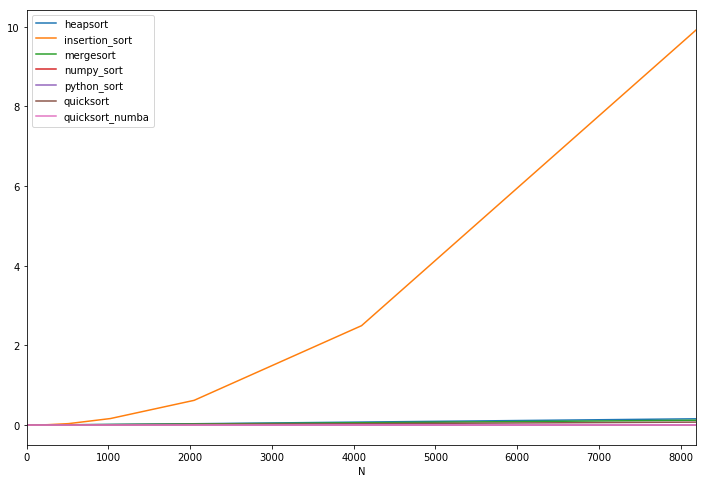

In [46]:
def benchmark_sort(sort, data, number=1):
    # FIXME: use autorange to determine number, do re
    # FIXME: copy() the data and do repetitions
    # FIXME: run just copy alone and check that it is very low influence (or subtract it)
    # FIXME: return data normalized per run (divide by number of executions).
    # TODO: return not just min value?
    timer = timeit.Timer('sort(data)', globals=locals())
    times = timer.repeat(repeat=1, number=number) # XXX: cannot use repeat, because first run sorts the data
    best = min(times)
    return best

inefficient_sorts = { insertion_sort }
efficient_sorts = { heapsort, quicksort, mergesort }
native_sorts = { python_sort, numpy_sort, quicksort_numba }
all_sorts = inefficient_sorts | efficient_sorts | native_sorts

def benchmark_comparison(data_generator, max_n=8192, algorithms=None):
    if algorithms is None:
        algorithms = all_sorts
    
    N = [ 2**i for i in range(1, int(math.log(max_n, 2)+1)) ]
    print(N)
    
    inputs = [ data_generator(n) for n in N ]
    series = { 'N': N }
    for func in algorithms:
        name = func.__name__
        # FIXME: move copy step into benchmark
        series[name] = [ benchmark_sort(func, i.copy()) for i in inputs ]        
    return pandas.DataFrame(series)

df = benchmark_comparison(random_integers)
df.plot(x='N', figsize=(12, 8))
            

[2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096, 8192]


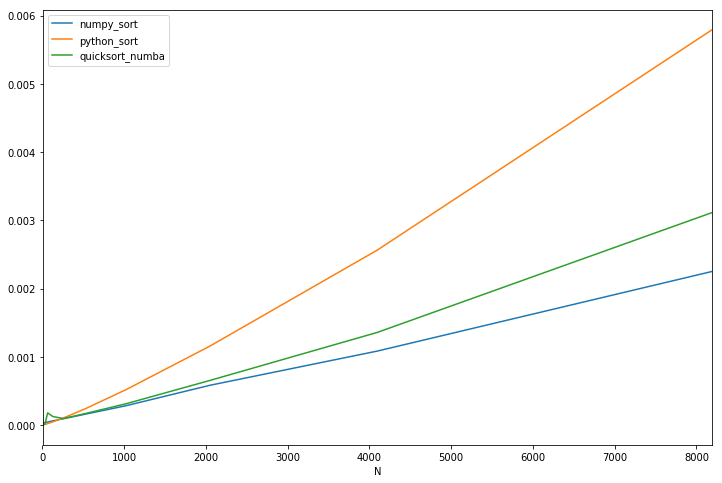

In [42]:
df = benchmark_comparison(random_integers, algorithms=native_sorts)
df.plot(x='N', figsize=(12, 8))

[2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096, 8192]


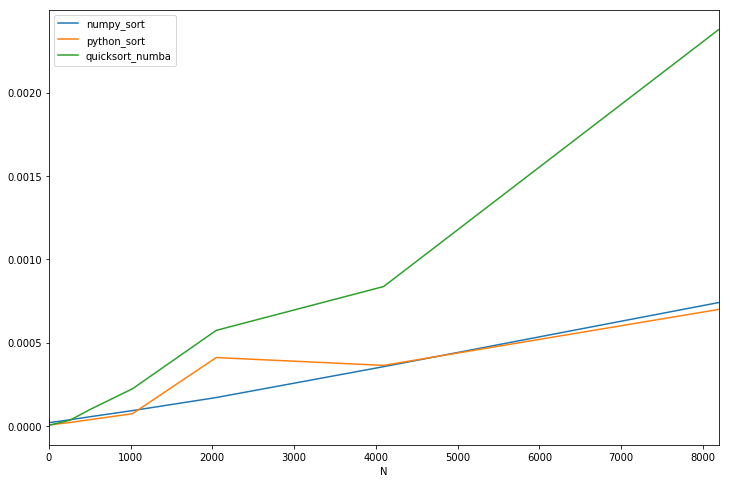

In [43]:
df = benchmark_comparison(random_numpy, algorithms=native_sorts)
df.plot(x='N', figsize=(12, 8))

[2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096, 8192]


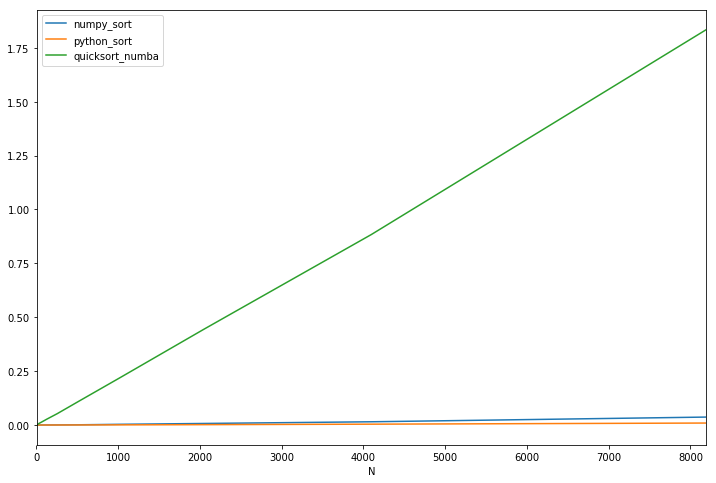

In [44]:
df = benchmark_comparison(random_strings, algorithms=native_sorts)
df.plot(x='N', figsize=(12, 8))

[2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096, 8192]


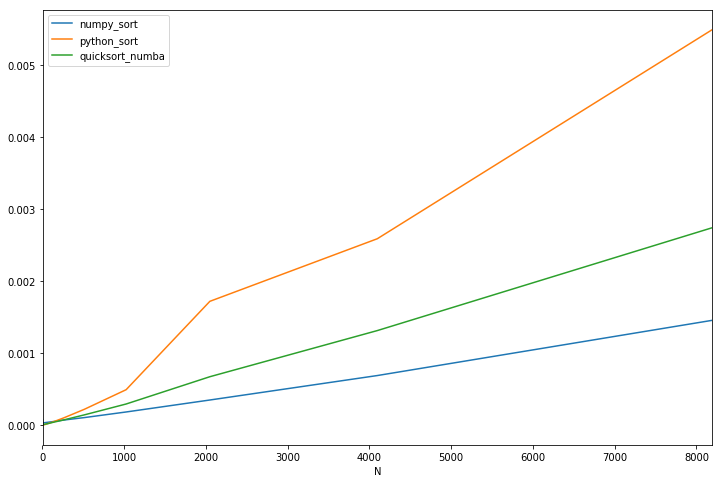

In [50]:
df = benchmark_comparison(random_floats, algorithms=native_sorts)
df.plot(x='N', figsize=(12, 8))

## Results

TODO: algo compare with theory
for each sort function, plot results acrosss N on different input data distributions
max_n=1000000, except insertion sort
Use a helper function for each plot
Make comments for each, compared with expected

MAYBE: find values for c for fitting the (expected) O() bounds, insert into plot as reference
Should be done using an optimizer. Report the error (distance-squared?)?

TODO: algo comparison
For each data type, plots execution times for all sorting functions


TODO: Numbas improvement
for each data type, plot versus original/numpy/Python
, plot improvement over original

## Discussion

Discuss your results in light of the expectations from the theoretical runtime analysis we performed in class for different types of test data. Comment on unexpected or surprising results. Try to interpret your results.

Can mention improvements that exist to algorithms for improving worst-case

## Conclusions